# Проект по Python - анализ данных с Auto.ru
##### Проект по курсу «Наука о данных», Совместный бакалавриат ВШЭ-РЭШ

##### Автор работы: Артур Хайбрахманов.

### Описание:
Этот проект автоматически собирает данные с известного сайта Auto.ru, затем преобразует полученные данные в датафрейм, анализирует их, используя различные математические функции, метод линейной регрессии и визуализацию. В конце можно полюбоваться отмеченными на карте адресами дилерских центров Mercedes в Москве и помечтать о том, чтобы когда-нибудь в них заехать (на БМВ, разумеется).

#### Использованные возможности: 
Продвинутый веб-скреппинг с использованием Selenium, выгрузка данных при помощи BeutifulSoup, продвинутые возможности Pandas, несколько видов визуализации данных при помощи Plotly, интерактивная карта, созданная при помощи folium, линейная регрессия (не смейтесь, мы этого вообще не проходили. Я лично горд собой), а также вагон и маленькая тележка регулярок.

В дальнейшем в проекте будут присутствовать текстовые комментарии для более простой навигации.


Сначала подключим библиотеки - нужные и ненужные:

In [879]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
from matplotlib import pyplot as plt
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.common.by import By
from tqdm import tqdm
import re
import folium
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

Определим функцию, которая будет помогать получать данные с сайта. Эта функция принимает на вход строку с дополнительной информацией об автомобиле и преобразует ее в чуть более читаемый вид

In [669]:
def get_first_word(s):
    pattern = re.compile(r'^([А-ЯЁ][а-яё]*(?:[ -][А-ЯЁ][а-яё]*)*)([А-ЯЁ][а-яё]*)?')
    match = pattern.match(s)
    if match:
        return match.group(1).replace('станция', '')
    else:
        return s

#### Получаем данные с сайта:
Я и супчик заваривал, и selenium использовал. Некоторые данные пришлось отдельно доставать регулярками, потому что они находились в одном блоке (например, информация об объеме двигателя и лошадиных силах). На случай, если каких-то данных недостает, пропишем игнор предупреждений (я проверял, серьезных ошибок не выскакивает). В конце концов, создаем список data и жестко добавляем в него 2 ведра полученной информации.

In [671]:
data = []
driver = webdriver.Chrome()
url = 'https://auto.ru/moskva/cars/all/'
driver.get(url)
spans = driver.find_element(By.CLASS_NAME, 'TextInput__control')
spans.send_keys('Мерседес')
sleep(1)
spans.send_keys(Keys.ENTER)
sleep(3)
for p in range(100):
    soup = BeautifulSoup(driver.page_source, 'lxml')
    cars = soup.findAll('div', class_="ListingItem")
    for car in cars:
        try:
            name = car.find('h3', class_="ListingItem__title").text.strip()
            link = car.find('a', class_="ListingItemTitle__link").get('href')
            engine_fuel_summary = car.find('div', class_="ListingItemTechSummaryDesktop__cell").text.strip()
            engine_capacity = ''.join(re.findall('\d\.\d', engine_fuel_summary))
            horsepower = ''.join(re.findall('\d\d\d', engine_fuel_summary))
            fuel = ''.join(re.findall('Бензин|Дизель|Газ|Электричество', engine_fuel_summary))
            transmission = driver.find_element(By.XPATH, \
                                       '/html/body/div[2]/div/div[2]/div[3]/div[2]/div/div[2]/ \
                                       div/div[10]/div[2]/div/div[2]/div[1]/div/div[1]/div[2]').text
            body_type = driver.find_element(By.XPATH, \
                                       '/html/body/div[2]/div/div[2]/div[3]/ \
                                       div[2]/div/div[2]/div/div[10]/div[2]/div/div[2]/div[1]/div/div[1]/div[3]').text
            price = car.find('div', class_="ListingItem__price").text.replace('\xa0', ' ')
            if 'от' in price:
                price = price.replace('от ', '')
            price = int(price.replace(' ₽', '').replace(' ', ''))
            year = int(car.find('div', class_="ListingItem__yearBlock").text)
            kmAge = car.find('div', class_="ListingItem__kmAge").text.replace('\xa0', ' ')
            location = car.find('div', class_="ListingItem__additionalInfo").text.replace('\xa0', ' ').strip()
            location = get_first_word(location)
        except Exception:
            pass
        finally:
            data.append([name, engine_capacity, horsepower, fuel, transmission, body_type, price, kmAge, location, link])
    driver.find_element(By.XPATH, '/html/body/div[2]/div/div[2]/div[3]/div[2]/div/div[2]/div/div[11]/div/div/a[2]/span/span').click()
    sleep(5)

Получили 3700 мерседесов. Достаточно, чтобы анализировать

In [672]:
len(data)

3700

Теперь из списка создаем датафрейм. 
Пришлось немного поковыряться руками, чтобы он выглядел поприличнее, но результатом я остался доволен.
Небольшое добавление - на сайте авто.ру информация о топливе для электромобилей записывается несколько не так, как нам хотелось бы ее видеть. Поэтому руками меняем то, что нам предлагает сайт.

In [835]:
columns = ['Название', 'Объем_двигателя', 'Лошадиные_силы', 'Топливо', 'Коробка_передач', \
           'Тип_кузова', 'Цена', 'Пробег', 'Расположение', 'Ссылка']
index = range(3700)
df = pd.DataFrame(data, index, columns)
df['Пробег'] = df['Пробег'].replace('Новый', '0 км')
df['Пробег'] = df['Пробег'].replace('км', '', regex = True).replace(' ', '', regex = True)
df = df.astype({'Пробег': int})
df['Коробка_передач'] = df['Коробка_передач'].replace('Заряд на 642 км', 'электрическая')
df['Расположение'] = df['Расположение'].replace('станция ', '', regex = True)
df['Расположение'] = df['Расположение'].apply(lambda x: str(x.split()[0]))
df['Расположение'] = df['Расположение'].replace('[0-9]*', '', regex = True)
df['Расположение'] = df['Расположение'].replace('Москва', '', regex = True)
df['Расположение'] = df['Расположение'].replace('МоскворечьеКантемировская', 'Москворечье', regex = True)
df['Расположение'] = df['Расположение'].replace('Парк', 'Парк Культуры', regex = True)
df['Расположение'] = df['Расположение'].replace('БескудниковоСелигерская', 'Бескудниково', regex = True)
df['Расположение'] = df['Расположение'].replace('Речной', 'Речной Вокзал', regex = True)
df['Расположение'] = df['Расположение'].replace('Красный', 'Красный Балтиец', regex = True)
df['Расположение'] = df['Расположение'].replace('ТестовскаяВыставочная', 'Тестовская', regex = True)
df['Расположение'] = df['Расположение'].replace('СетуньРабочий', 'Сетунь', regex = True)

In [836]:
df.head(5)

,Название,Объем_двигателя,Лошадиные_силы,Топливо,Коробка_передач,Тип_кузова,Цена,Пробег,Расположение,Ссылка
0,Mercedes-Benz Maybach S-Класс 580 II (Z223),4.0,503,Бензин,автомат,седан,34780000,60,Шелепиха,https://auto.ru/cars/used/sale/mercedes/s_clas...
1,Mercedes-Benz Maybach S-Класс 580 II (Z223),4.0,503,Бензин,автомат,седан,34950000,60,Шелепиха,https://auto.ru/cars/used/sale/mercedes/s_clas...
2,Mercedes-Benz Vito 110 CDI L1 III (W447),2.0,102,Дизель,автомат,седан,6745000,0,Тула,https://auto.ru/cars/new/group/mercedes/vito/2...
3,Mercedes-Benz Maybach S-Класс 680 II (Z223),6.0,612,Бензин,автомат,седан,36990000,30,Шелепиха,https://auto.ru/cars/used/sale/mercedes/s_clas...
4,Mercedes-Benz GLS 580 II (X167),4.0,489,Бензин,автомат,седан,17570000,0,Южная,https://auto.ru/cars/new/group/mercedes/gls_kl...


Давайте немного поизучаем наш датасет. Здесь группировка по типу кузова и средняя цена + пробег для каждого типа кузова. 

In [850]:
df.groupby('Тип_кузова')[['Цена', 'Пробег']].mean()

,Цена,Пробег
Тип_кузова,,
внедорожник 5 дв.,9.260352e+06,71263.840952
купе,8.767356e+06,71940.054054
купе-хардтоп,1.154702e+07,64805.445946
лифтбек,1.151902e+07,74432.621622
минивэн,8.189553e+06,84523.333333
седан,8.929208e+06,76818.718799
хэтчбек 5 дв.,8.608562e+06,86644.752896


Группировка по колонкам типа кузова и коробки передач, + вывод значений в отсортированном по убыванию порядке:

In [851]:
df.groupby(['Тип_кузова', 'Коробка_передач']).size().sort_values(ascending=False)

Тип_кузова         Коробка_передач
внедорожник 5 дв.  автомат            1449
седан              автомат            1266
минивэн            автомат             393
хэтчбек 5 дв.      робот               259
внедорожник 5 дв.  робот               148
купе               автомат              74
купе-хардтоп       автомат              74
лифтбек            электрическая        37
dtype: int64

Ради интереса (и чтобы заработать побольше баллов за использование Pandas) вычисленим экспоненциальное взвешенное скользящего среднего для цены автомобилей

In [853]:
df['Цена'].ewm(span=5, adjust=False).mean()

0       3.478000e+07
1       3.483667e+07
2       2.547278e+07
3       2.931185e+07
4       2.539790e+07
            ...     
3695    8.817676e+06
3696    6.928450e+06
3697    6.038634e+06
3698    5.025756e+06
3699    4.933837e+06
Name: Цена, Length: 3700, dtype: float64

На случай, если вам захочется насладиться видом шикарных автомобилей, я сделал ссылки кликабельными:

In [838]:
def clickable_link_to_the_car(link): 
    return f'<a href="{link}">{link}</a>'

styled_df = df.style.format({'Ссылка': clickable_link_to_the_car})

Чтобы потыкать на ссылки, уберите решетку. Откроется большая таблица (которая на самом деле не совсем таблица)

In [880]:
#styled_df

Теперь можно и визуализировать что-нибудь. Начнем с распределения цен на "Мерсы" и немного удивимся - ожидалось увидеть распределение значительно правее. Наверное, многие из этих автомобилей с большим пробегом, а потому дешево продаются относительно цен в дилерских центрах.

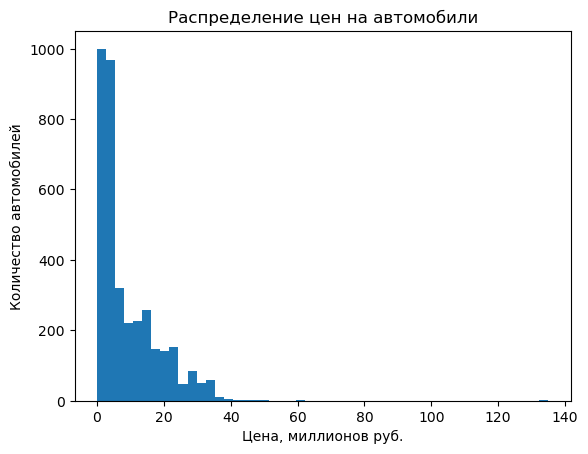

In [854]:
def thousands(x, pos):
    return '{:,.0f}'.format(x/1000000).replace(',', ' ')
prices = df['Цена']
fig, ax = plt.subplots()
ax.hist(prices, bins=50)
ax.xaxis.set_major_formatter(FuncFormatter(thousands)) 
plt.title('Распределение цен на автомобили')
plt.xlabel('Цена, миллионов руб.')
plt.ylabel('Количество автомобилей')
plt.show()

Теперь посмотрим, какая доля автомобилей с какой коробкой передач. Как можно видеть, в нашей выборке преобладают Мерседесы с автоматической коробкой. Что неудивительно - они в целом среди Мерседесов преобладают.

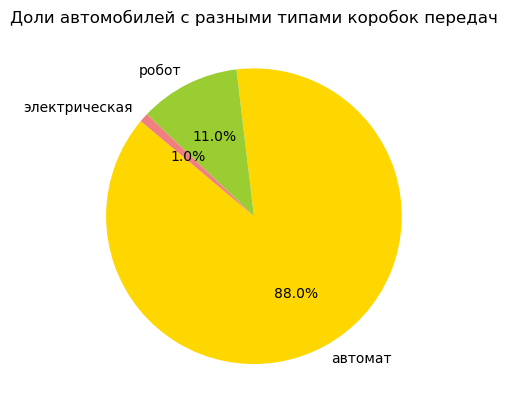

In [856]:
counts = df['Коробка_передач'].value_counts()
labels = counts.index.tolist()
sizes = (counts/counts.sum()).tolist()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.title('Доли автомобилей с разными типами коробок передач')
plt.show()

Чуть выше я обмолвился, что чем больше у автомобиля пробег, тем меньше он стоит. Давайте на примере нашей выборки посмотрим, правда ли это. Построим линейную регрессию для предсказания стоимости автомобиля по пробегу. Она, конечно, не очень сложная, но зато своя и понятная. Заодно посчитаем коэффициент корреляции и убедимся еще раз, что высок шанс того, что чем больше пробег, тем меньше цена (при прочих равных).

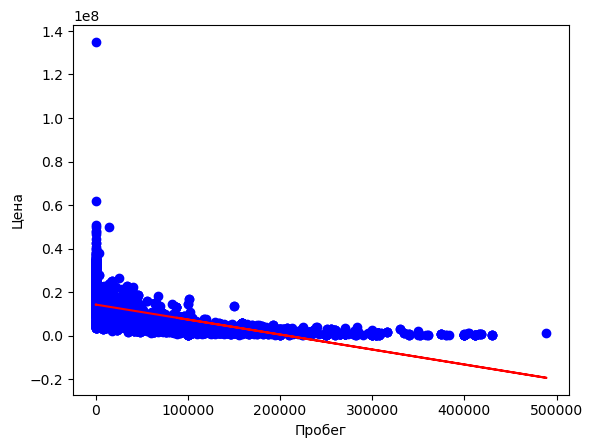

In [857]:
X = df[['Пробег']]
y = df['Цена']
model = LinearRegression()
model.fit(X, y)
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.xlabel('Пробег')
plt.ylabel('Цена')
plt.show()

In [873]:
df['Цена'].corr(df['Пробег'])

-0.6161155709188524

На фоне всей это замурчательности Мерседесов хотелось бы узнать, где их купить. Разумеется, перейдя по (кликабельным!) ссылкам из моего датасета можно пристрелиться, но многие все же предпочитают ехать к официальным поставщикам. Где их найти? Сейчас будем узнавать. Пока что готовим данные, используя суп и "селениум". Запишем адреса в файлик. Затем пробьем адреса и вычислим координаты. Запишем это дело в массив. После некоторого количества манипуляций таки получаем аккуратный датафрейм.

In [862]:
url = 'https://www.auto-dealer.ru/dealers/city-moscow/mark-mercedes-benz/?city=moscow&brand=mercedes-benz'
browser = webdriver.Chrome()
browser.get(url)
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
results = soup.findAll('div', class_ = "dealers-list__item")
with open('mercedes_dealers.txt', 'w', encoding = 'utf-8') as file:
    for result in results:
        address = result.find('div', {'class': 'dealers-list__address'}).text.strip()
        print(address, file = file)
browser.find_element(By.CLASS_NAME, 'bx-pag-next').click()
sleep(3)
response2 = browser.page_source
soup2 = BeautifulSoup(response2, 'html.parser')
results2 = soup2.findAll('div', class_ = "dealers-list__item")
with open('mercedes_dealers.txt', 'a', encoding = 'utf-8') as file: # use 'a' to append to the file instead of overwriting it
    for result2 in results2:
        address2 = result2.find('div', {'class': 'dealers-list__address'}).text.strip()
        print(address2, file = file)

In [826]:
coordinates = ['55.713949997657366,37.71960812526574', '55.752977,37.60514', '55.658865,37.895242', \
               '55.894015,37.697972', '55.908162,37.408256', '55.621211,37.616396', '55.593995,37.734955', \
              '55.784395,37.622244', '55.800559,37.28401', '55.653456,37.518129', '55.784627,37.869999', \
              '55.795585,37.541099', '55.917934,37.583886', '55.679057,37.419781', '55.73664,37.246865']

df_1 = pd.DataFrame([i.split(',') for i in coordinates], columns=['широта', 'долгота'])
df_1['широта'] = df_1['широта'].astype(float)
df_1['долгота'] = df_1['долгота'].astype(float)
print(df_1)

       широта    долгота
0   55.713950  37.719608
1   55.752977  37.605140
2   55.658865  37.895242
3   55.894015  37.697972
4   55.908162  37.408256
5   55.621211  37.616396
6   55.593995  37.734955
7   55.784395  37.622244
8   55.800559  37.284010
9   55.653456  37.518129
10  55.784627  37.869999
11  55.795585  37.541099
12  55.917934  37.583886
13  55.679057  37.419781
14  55.736640  37.246865


Создаем карту, указав координаты Москвы 

In [860]:
moscow_coordinates = [55.7558, 37.6173] 
m = folium.Map(location=moscow_coordinates, zoom_start=11) 

Затем создадим объект типа FeatureGroup и добавим на карту точки из датафрейма df_1. В результате получаем симпатичную карту, которую можно и повертеть, и подергать. Главное - все салоны на месте. Возможно, при переносе координат, они слегка сместились, или часть из них переместилась\покинула Россию официально, но по этим меткам точно можно ехать и покупать себе Мерседес. Красота!

In [861]:
locations = df_1[['широта', 'долгота']].values.tolist() 

fg = folium.FeatureGroup(name="Точки на карте")
for location in locations:
    fg.add_child(folium.Marker(location=location))
m.add_child(fg)

На этом у меня пока что все. В дальнейшем я решил не забрасывать проект и еще что-нибудь поделать с ним. Например, запилить тг-бота, который будет скидывать рандомные объявления о продаже Мерседесов при нажатии на кнопку. Чтобы добавить боту немного чувства юмора, я планирую добавить шанс скинуть ссылку на видеоклип одной известной песни на Ютубе. Собственно, я пытался написать бота, но пока что не получилось, и я решил не добавлять эту часть в проект. Спасибо за внимание